In [1]:
import kika
from kika.ace.analysis import get_cross_section_dataframe
import os
import math
import numpy as np
from collections import defaultdict
from kika.utils import configure_ace_debug_logging

# Configure debug logging
#configure_ace_debug_logging(enable=True)  # Set to False to disable debug output

In [29]:
def calcular_cocientes(listaA, listaB):
    if len(listaA) != len(listaB):
        raise ValueError("Las listas deben tener la misma longitud")
    return [a / b if b != 0 else float('nan') for a, b in zip(listaA, listaB)]

In [30]:
def comparar_cocientes(coc1, coc2, tolerancia=1e-9, max_diferencias=10):
    diferencias = []
    longitud = max(len(coc1), len(coc2))
    
    for i in range(longitud):
        try:
            x = coc1[i]
        except IndexError:
            diferencias.append((i, '–', coc2[i]))
            continue
        try:
            y = coc2[i]
        except IndexError:
            diferencias.append((i, coc1[i], '–'))
            continue
        
        # Si ambos son nan, los consideramos iguales
        if math.isnan(x) and math.isnan(y):
            continue
        # Si uno es nan y el otro no, es diferencia
        if math.isnan(x) or math.isnan(y):
            diferencias.append((i, x, y))
            continue
        
        if abs(x - y) >= tolerancia:
            diferencias.append((i, x, y))
        
        if len(diferencias) >= max_diferencias:
            break

    return diferencias

In [4]:
# Ejemplo de uso - calcular cocientes y comparar_cocientes

# lista1 = ace0.cross_section.reaction[101].xs_values
# lista2 = ace1.cross_section.reaction[101].xs_values
# lista3 = ace0.cross_section.reaction[102].xs_values
# lista4 = ace1.cross_section.reaction[102].xs_values

# cocientes_4  = calcular_cocientes(lista1, lista2)
# cocientes_51 = calcular_cocientes(lista3, lista4)
# 
# diffs = comparar_cocientes(cocientes_4, cocientes_51)
# 
# if not diffs:
#     print("Todos los cocientes coinciden (dentro de la tolerancia).")
# else:
#     total_diffs = len(diffs)
#     print(f"Se han encontrado {total_diffs} diferencia{'s' if total_diffs != 1 else ''}.")
#     print("Primeras diferencias encontradas (índice: cociente4 → cociente51):\n")
#     for idx, x, y in diffs:
#         print(f"  [{idx}]  {x!r}  →  {y!r}")
#     if total_diffs > len(diffs):
#         resto = total_diffs - len(diffs)
#         print(f"\n...y {resto} diferencia{'s' if resto != 1 else ''} más no mostrada{'s' if resto != 1 else ''}.")

In [31]:
def compare_mts(ace, sum_mts, ref_mt, interpolate_missing=False, tol=1e-8):
    """
    Compare the xs of ref_mt against the sum of xs over sum_mts, with tolerance
    and concise output.

    Parameters
    ----------
    ace : object
        Your ACE data container, with ace.cross_section.reaction[mt].energies
        and .xs_values.
    sum_mts : list of int
        MT numbers whose xs you want to sum.
    ref_mt : int
        MT number to compare the sum against.
    interpolate_missing : bool, optional
        If True, linearly interpolate summed xs onto the ref energy grid.
    tol : float, optional
        Tolerance for treating Δ = xs_ref – xs_sum as zero if |Δ| ≤ tol.

    Returns
    -------
    E_ref, xs_ref, xs_sum, delta : np.ndarray
        Arrays of reference energies, reference xs, summed xs, and their difference.
    """
    # 1) grab reference
    ref_rx = ace.cross_section.reaction[ref_mt]
    E_ref  = np.array(ref_rx.energies)
    xs_ref = np.array(ref_rx.xs_values)

    # 2) build sum map
    sum_xs = defaultdict(float)
    energy_set = set()
    for mt in sum_mts:
        rx = ace.cross_section.reaction[mt]
        for E, xs in zip(rx.energies, rx.xs_values):
            sum_xs[E] += xs
            energy_set.add(E)

    # 3) align on E_ref
    if interpolate_missing:
        Es_sorted = np.array(sorted(energy_set))
        xs_sorted = np.array([sum_xs[E] for E in Es_sorted])
        xs_sum = np.interp(E_ref, Es_sorted, xs_sorted)
    else:
        xs_sum = np.array([sum_xs.get(E, 0.0) for E in E_ref])

    # 4) compute delta and apply tolerance
    delta = xs_ref - xs_sum
    if tol > 0:
        small = np.abs(delta) <= tol
        delta[small] = 0.0

    # 5) print results
    # find indices where delta is non-zero
    idx = np.nonzero(delta)[0]
    if idx.size == 0:
        print(f"All {len(E_ref)} points match within a tolerance of {tol:e}.")
    else:
        header = f"{'E (MeV)':>12s} {'xs_ref':>12s} {'sum_xs':>12s} {'Δ':>12s}"
        print(header)
        print("-" * len(header))
        for i in idx:
            print(f"{E_ref[i]:12.6e} {xs_ref[i]:12.6e} {xs_sum[i]:12.6e} {delta[i]:12.6e}")

    return E_ref, xs_ref, xs_sum, delta

In [32]:
def compare_ace_sums(ace1, sum_mts1, ace2, sum_mts2,
                     interpolate_missing=False, tol=1e-8):
    """
    Compara la suma de secciones eficaces de dos objetos ACE.

    Parámetros
    ----------
    ace1 : objeto
        Contenedor ACE, con ace1.cross_section.reaction[mt].energies
        y .xs_values.
    sum_mts1 : list de int
        MTs cuya xs se sumará en ace1.
    ace2 : objeto
        Segundo contenedor ACE.
    sum_mts2 : list de int
        MTs cuya xs se sumará en ace2.
    interpolate_missing : bool, opcional
        Si True, interpola linealmente ambas sumas en una malla común.
    tol : float, opcional
        Tolerancia para considerar Δ = xs1 - xs2 como cero si |Δ| ≤ tol.

    Retorna
    -------
    E : np.ndarray
        Energías de referencia (malla común).
    xs1 : np.ndarray
        Valores de xs sumados para ace1.
    xs2 : np.ndarray
        Valores de xs sumados para ace2.
    delta : np.ndarray
        Diferencia xs1 - xs2 (valores pequeños puestos a cero).
    """
    # 1) construir mapas de energía→xs para cada ACE
    sum1 = defaultdict(float)
    sum2 = defaultdict(float)
    ener_set = set()

    # para ace1
    for mt in sum_mts1:
        rx = ace1.cross_section.reaction[mt]
        for E, xs in zip(rx.energies, rx.xs_values):
            sum1[E] += xs
            ener_set.add(E)

    # para ace2
    for mt in sum_mts2:
        rx = ace2.cross_section.reaction[mt]
        for E, xs in zip(rx.energies, rx.xs_values):
            sum2[E] += xs
            ener_set.add(E)

    # 2) definir malla de energías de referencia
    if interpolate_missing:
        # usamos la malla unificada ordenada
        E_ref = np.array(sorted(ener_set))
        xs1_vals = np.array([sum1[E] for E in E_ref])
        xs2_vals = np.array([sum2[E] for E in E_ref])
        # ya están en la misma malla, no hay que interpolar de otro origen
        xs1 = xs1_vals
        xs2 = xs2_vals
    else:
        # tomamos malla de ace1 si queremos priorizar
        # pero aquí usamos la malla unificada
        E_ref = np.array(sorted(ener_set))
        xs1 = np.array([sum1.get(E, 0.0) for E in E_ref])
        xs2 = np.array([sum2.get(E, 0.0) for E in E_ref])

    # 3) cálculo de la diferencia y aplicación de tolerancia
    delta = xs1 - xs2
    if tol > 0:
        mask = np.abs(delta) <= tol
        delta[mask] = 0.0

    # 4) salida de resultados
    idx = np.nonzero(delta)[0]
    if idx.size == 0:
        print(f"Todas las {len(E_ref)} energías coinciden dentro de tol={tol:e}.")
    else:
        header = f"{'E (MeV)':>12s} {'xs1':>12s} {'xs2':>12s} {'Δ':>12s}"
        print(header)
        print("-" * len(header))
        for i in idx:
            print(f"{E_ref[i]:12.6e} {xs1[i]:12.6e} {xs2[i]:12.6e} {delta[i]:12.6e}")

    return E_ref, xs1, xs2, delta


In [33]:
def compare_lists(lista_a, lista_b, tolerancia=1e-8, show=False):
    """
    Compara dos listas de valores y devuelve las diferencias que superan la tolerancia.
    
    Args:
        lista_a (list): Primera lista de valores.
        lista_b (list): Segunda lista de valores.
        tolerancia (float): Tolerancia para la comparación.
        
    Returns:
        list: Lista de tuplas con (índice, valor de lista_a, valor de lista_b) donde hay diferencias.
    """
    diferencias = []
    
    for i, (x, y) in enumerate(zip(lista_a, lista_b)):
        if not math.isclose(x, y, rel_tol=tolerancia, abs_tol=tolerancia):
            diferencias.append((i, x, y))
    
    if diferencias:
        print("Diferencias encontradas (considerando tolerancia):")
        if show:
            for idx, val_a, val_b in diferencias:
                print(f"Índice {idx}: lista_a = {val_a}, lista_b = {val_b}")
    else:
        print("Las listas son iguales dentro de la tolerancia definida.")
    
    return diferencias

In [2]:
acefile0 = '/home/MONLEON-JUAN/KIKA/kika/ace/files/922350_71.02c'
acefile1 = '/home/MONLEON-JUAN/KIKA/kika/ace/files/922350_71.02c_0001'

In [ ]:
acefile0 = '/home/MONLEON-JUAN/KIKA/kika/ace/files/10010_71.02c'
acefile1 = '/home/MONLEON-JUAN/KIKA/kika/sampling/new_perturbed_ace_files/1001/0001/10010_71_0001.02c'

In [122]:
acefile0 = '/home/MONLEON-JUAN/KIKA/kika/ace/files/260560_80.02c'
acefile1 = '/home/MONLEON-JUAN/KIKA/kika/sampling/new_perturbed_ace_files/26056/0001/260560_80_0001.02c'

In [34]:
acefile0 = '/home/MONLEON-JUAN/KIKA/kika/sampling/perturbed_ace_files/260540_80_0010.06c'
acefile1 = '/home/MONLEON-JUAN/KIKA/kika/sampling/perturbed_ace_files/260540_80.06c_0001_F'

In [7]:
acefile2 = '/home/MONLEON-JUAN/KIKA/kika/sampling/new_perturbed_ace_files/26056/0001/260560_80_0001.02c'
acefile3 = '/home/MONLEON-JUAN/KIKA/kika/ace/files/260560_80.02c_0001'

In [8]:
acefile = '/home/MONLEON-JUAN/KIKA/kika/ace/files/260560_80.02c'
ace = kika.read_ace(acefile)

In [3]:
ace0 = kika.read_ace(acefile0)
ace1 = kika.read_ace(acefile1)

In [5]:
acefile0 = '/share_snc/snc/JuanMonleon/COV/ace/81_MF4_40/293.6/80160_81_MF4_40.02c'
ace0 = kika.read_ace(acefile0)

In [6]:
ace0.angular_distributions

                              Angular Distribution Container                              

This container holds angular distributions read directly from the ACE file.
Each distribution preserves the original data structure as found in the ACE format.

Angular distributions describe the probability of scattering as a function of the
cosine of the scattering angle (μ), which ranges from -1 (backward scattering) to
+1 (forward scattering).

Available Angular Distribution Data:
------------------------------------------------------------------------------------------
Distribution Type                        Status                                         
------------------------------------------------------------------------------------------
Elastic Scattering (MT=2)                Available (TABULATED)                          
Neutron Reactions                        Available (10 reactions)                       
  KALBACH_MANN                           10 reactions                  

In [19]:
if ace0.unresolved_resonance is not None:
    print(f"ace0 tiene resonancias no resueltas.")
else:
    print("ace0 no tiene resonancias no resueltas.")

ace0 tiene resonancias no resueltas.


In [22]:
ace0.unresolved_resonance.has_data

False

In [9]:
ace2 = kika.read_ace(acefile2)
ace3 = kika.read_ace(acefile3)

In [49]:
print(ace.mt_numbers)

[1, 2, 5, 16, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 101, 102, 103, 107, 111, 203, 204, 205, 206, 207, 444, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 649, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818]


In [107]:
inelastic = [51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91]

In [36]:
total = [2, 5, 16, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 101]

In [40]:
print(ace0.mt_numbers)

[1, 2, 5, 16, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 91, 101, 102, 103, 107, 111, 203, 204, 205, 206, 207, 444, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 649, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823]


In [41]:
total = [2, 5, 16, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 91, 101]

In [109]:
lista_mt3 = [5, 16, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91]

In [ ]:
lista_comp = [102,103,107,111]

In [42]:
compare_ace_sums(ace0, total, ace1, total, tol=1e-6);

Todas las 35934 energías coinciden dentro de tol=1.000000e-06.


In [55]:
compare_mts(ace0, total, 1, tol=1e-6);

All 35934 points match within a tolerance of 1.000000e-06.


In [56]:
compare_mts(ace1, total, 1, tol=1e-2);

All 35934 points match within a tolerance of 1.000000e-02.


In [25]:
compare_lists(list1, list2, tolerancia=1e-6, show=True);

Las listas son iguales dentro de la tolerancia definida.


In [59]:
for i in ace0.mt_numbers:
    list1 = ace0.cross_section.reaction[i].xs_values
    list2 = ace1.cross_section.reaction[i].xs_values
    res = compare_lists(list1, list2, tolerancia=1e-3);
    if res:
        print(f"OJO! Se encontraron diferencias en la reacción {i}.")
    else:
        print(f"No se encontraron diferencias en la reacción {i}.")

Las listas son iguales dentro de la tolerancia definida.
No se encontraron diferencias en la reacción 1.
Las listas son iguales dentro de la tolerancia definida.
No se encontraron diferencias en la reacción 2.
Las listas son iguales dentro de la tolerancia definida.
No se encontraron diferencias en la reacción 5.
Las listas son iguales dentro de la tolerancia definida.
No se encontraron diferencias en la reacción 16.
Las listas son iguales dentro de la tolerancia definida.
No se encontraron diferencias en la reacción 51.
Las listas son iguales dentro de la tolerancia definida.
No se encontraron diferencias en la reacción 52.
Las listas son iguales dentro de la tolerancia definida.
No se encontraron diferencias en la reacción 53.
Las listas son iguales dentro de la tolerancia definida.
No se encontraron diferencias en la reacción 54.
Las listas son iguales dentro de la tolerancia definida.
No se encontraron diferencias en la reacción 55.
Las listas son iguales dentro de la tolerancia de

In [61]:
compare_lists(list1, list2, tolerancia=1e-8);

Diferencias encontradas (considerando tolerancia):
Índice 27547: lista_a = 2.36390283838, lista_b = 2.36452805946
Índice 27548: lista_a = 2.56091194067, lista_b = 2.56225881469
Índice 27549: lista_a = 2.64715239207, lista_b = 2.64881460264
Índice 27550: lista_a = 2.83055529351, lista_b = 2.83256923898
Índice 27551: lista_a = 3.38800530386, lista_b = 3.3903649025
Índice 27552: lista_a = 3.70270463304, lista_b = 3.70540989484
Índice 27553: lista_a = 3.98868514018, lista_b = 3.99173606515
Índice 27554: lista_a = 3.85041267516, lista_b = 3.8538092633
Índice 27555: lista_a = 3.07683347018, lista_b = 3.08092745636
Índice 27556: lista_a = 2.7372650028, lista_b = 2.74238263069
Índice 27557: lista_a = 2.73280256345, lista_b = 2.7379710063
Índice 27558: lista_a = 2.55828025816, lista_b = 2.57007718645
Índice 27559: lista_a = 2.40596635029, lista_b = 2.41907973633
Índice 27560: lista_a = 2.44211899935, lista_b = 2.45765744575
Índice 27561: lista_a = 2.44546125986, lista_b = 2.46133346012
Índice 2

In [65]:
list1 = ace0.cross_section.reaction[101].xs_values
list2 = ace1.cross_section.reaction[101].xs_values
#lista3 = ace0.cross_section.reaction[51].xs_values
#lista4 = ace1.cross_section.reaction[51].xs_values

In [66]:
tolerancia = 1e-3  # Ajusta según lo preciso que quieras ser

diferencias = []

for i, (x, y) in enumerate(zip(list1, list2)):
    if not math.isclose(x, y, rel_tol=tolerancia, abs_tol=tolerancia):
        diferencias.append((i, x, y))

if diferencias:
    print("Diferencias encontradas (considerando tolerancia):")
    for idx, val1, val2 in diferencias:
        print(f"Índice {idx}: lista1 = {val1}, lista2 = {val2}")
else:
    print("Las listas son iguales dentro de la tolerancia definida.")


Las listas son iguales dentro de la tolerancia definida.


In [134]:
print(len(lista1), len(lista3))

371 430


In [137]:
cocientes_4  = calcular_cocientes(lista1, lista2)
cocientes_51 = calcular_cocientes(lista3, lista4)

diffs = comparar_cocientes(cocientes_4, cocientes_51, tolerancia=1e-3)

if not diffs:
    print("Todos los cocientes coinciden (dentro de la tolerancia).")
else:
    total_diffs = len(diffs)
    print(f"Se han encontrado {total_diffs} diferencia{'s' if total_diffs != 1 else ''}.")
    print("Primeras diferencias encontradas (índice: cociente4 → cociente51):\n")
    for idx, x, y in diffs:
        print(f"  [{idx}]  {x!r}  →  {y!r}")
    if total_diffs > len(diffs):
        resto = total_diffs - len(diffs)
        print(f"\n...y {resto} diferencia{'s' if resto != 1 else ''} más no mostrada{'s' if resto != 1 else ''}.")

Se han encontrado 10 diferencias.
Primeras diferencias encontradas (índice: cociente4 → cociente51):

  [195]  1.0022677612289548  →  0.9999999911793828
  [196]  1.0022677612297355  →  0.999999988877423
  [197]  1.0022677612303756  →  0.999999988878145
  [198]  1.0022677612305062  →  0.9999999888800256
  [199]  1.0022677612303648  →  0.9999999888800489
  [200]  1.0022677612303648  →  0.9999999888767529
  [201]  1.0022677612303625  →  0.9999999888766475
  [202]  1.0022677612303625  →  0.9999999888765579
  [203]  1.002267761230114  →  0.9999999888770934
  [204]  1.002267761230197  →  0.9999999888775392


In [39]:
acefile0 = '/home/MONLEON-JUAN/KIKA/kika/ace/files/922350_71.02c'
acefile1 = '/home/MONLEON-JUAN/KIKA/kika/ace/files/922350_71.02c_0001'

In [42]:
ace0 = kika.read_ace(acefile0)
ace1 = kika.read_ace(acefile1)

In [74]:
compare_mts(ace0, [102], 101);

All 76525 points match within a tolerance of 0.000000e+00.


In [98]:
print(ace0.mt_numbers)

[1, 2, 4, 16, 17, 18, 37, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 101, 102, 444]


In [111]:
compare_mts(ace0, total, 1, tol=1e-4);

All 76525 points match within a tolerance of 1.000000e-04.


In [87]:
compare_mts(ace0, inelastic, 4, tol=1e-6);

All 430 points match within a tolerance of 1.000000e-06.


In [ ]:
print(ace0.mt_numbers)

[1, 2, 4, 16, 17, 18, 37, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 101, 102, 444]


In [68]:
# 1) sum MTs 51 & 52, compare to MT 4, tol=3e-9:
E, x4, sum512, Δ1 = compare_mts(ace0, [51, 52], 4, tol=3e-9)

     E (MeV)       xs_ref       sum_xs            Δ
---------------------------------------------------
2.750000e-02 1.119965e-02 1.119965e-02 3.000000e-09
2.830000e-02 1.171770e-02 1.171770e-02 3.000000e-09
2.880000e-02 1.204155e-02 1.204155e-02 -4.000000e-09
3.110000e-02 1.346653e-02 1.346653e-02 -4.000000e-09
3.180000e-02 1.387887e-02 1.387887e-02 -3.000000e-09
3.210000e-02 1.405555e-02 1.405555e-02 3.000000e-09
3.280000e-02 1.446789e-02 1.446789e-02 4.000000e-09
3.420000e-02 1.529247e-02 1.529246e-02 5.000000e-09
3.500000e-02 1.576370e-02 1.576370e-02 5.000000e-09
3.790000e-02 1.747184e-02 1.747184e-02 -3.000000e-09
4.200000e-02 1.977802e-02 1.977802e-02 5.000000e-09
4.380000e-02 2.074028e-02 2.074028e-02 -4.000000e-09
4.430000e-02 2.100760e-02 2.100760e-02 3.000000e-09
4.500000e-02 2.138178e-02 2.138178e-02 3.600000e-09
4.600000e-02 2.191642e-02 2.191642e-02 -4.000000e-09
4.639827e-02 2.211188e-02 2.211188e-02 -3.200000e-09
4.680000e-02 2.644361e-02 2.230908e-02 4.134528e-03
4.730

In [62]:
import numpy as np
from collections import defaultdict

# 1. Get reaction 4 data
energies4 = ace0.cross_section.reaction[4].energies
xs4       = ace0.cross_section.reaction[4].xs_values

# 2. Sum xs over MT = 51..91, grouping by exact energy
sum_xs_by_E = defaultdict(float)
for mt in range(51, 92):
    rx = ace0.cross_section.reaction[mt]
    for E, xs in zip(rx.energies, rx.xs_values):
        sum_xs_by_E[E] += xs

# 3. Align to reaction 4’s energies
xs_sum_aligned = [ sum_xs_by_E.get(E, 0.0) for E in energies4 ]

# 4. Compare (example: print a few lines)
for E, x4, xs_sum in zip(energies4, xs4, xs_sum_aligned):
    diff = x4 - xs_sum
    print(f"E={E:.6e}   xs4={x4:.6e}   sum51–91={xs_sum:.6e}   Δ={diff:.6e}")


E=2.249999e-03   xs4=0.000000e+00   sum51–91=0.000000e+00   Δ=0.000000e+00
E=2.250001e-03   xs4=1.204971e-07   sum51–91=1.204971e-07   Δ=0.000000e+00
E=2.300000e-03   xs4=1.251350e-07   sum51–91=1.251350e-07   Δ=0.000000e+00
E=2.400000e-03   xs4=1.342625e-07   sum51–91=1.342625e-07   Δ=0.000000e+00
E=2.500000e-03   xs4=1.433900e-07   sum51–91=1.433900e-07   Δ=0.000000e+00
E=2.650000e-03   xs4=1.570820e-07   sum51–91=1.570820e-07   Δ=0.000000e+00
E=2.775000e-03   xs4=1.684920e-07   sum51–91=1.684920e-07   Δ=0.000000e+00
E=2.900000e-03   xs4=1.799020e-07   sum51–91=1.799020e-07   Δ=0.000000e+00
E=3.000000e-03   xs4=1.890300e-07   sum51–91=1.890300e-07   Δ=0.000000e+00
E=3.150000e-03   xs4=2.471490e-07   sum51–91=2.471490e-07   Δ=0.000000e+00
E=3.250000e-03   xs4=2.858950e-07   sum51–91=2.858950e-07   Δ=0.000000e+00
E=3.375000e-03   xs4=3.343275e-07   sum51–91=3.343275e-07   Δ=0.000000e+00
E=3.500000e-03   xs4=3.827600e-07   sum51–91=3.827600e-07   Δ=0.000000e+00
E=3.700000e-03   xs4=4.60

In [107]:
ace0.cross_section.reaction[4]._xs_entries[1].value

1.204971e-07

In [32]:
for i in range(len(ace2.cross_section.reaction[4]._xs_entries)):
    print(f"{ace2.cross_section.reaction[4]._xs_entries[i].value:.6e}")
    ace2.cross_section.reaction[4]._xs_entries[i].value = 0.0
    print(f"{ace2.cross_section.reaction[4]._xs_entries[i].value:.6e}")

0.000000e+00
0.000000e+00
1.204971e-07
0.000000e+00
1.251350e-07
0.000000e+00
1.342625e-07
0.000000e+00
1.433900e-07
0.000000e+00
1.570820e-07
0.000000e+00
1.684920e-07
0.000000e+00
1.799020e-07
0.000000e+00
1.890300e-07
0.000000e+00
2.471490e-07
0.000000e+00
2.858950e-07
0.000000e+00
3.343275e-07
0.000000e+00
3.827600e-07
0.000000e+00
4.602520e-07
0.000000e+00
4.989980e-07
0.000000e+00
5.377430e-07
0.000000e+00
5.764890e-07
0.000000e+00
6.346080e-07
0.000000e+00
6.733540e-07
0.000000e+00
7.121000e-07
0.000000e+00
7.702190e-07
0.000000e+00
8.864570e-07
0.000000e+00
9.639490e-07
0.000000e+00
1.075280e-06
0.000000e+00
1.223730e-06
0.000000e+00
1.335060e-06
0.000000e+00
1.409280e-06
0.000000e+00
1.446400e-06
0.000000e+00
1.557730e-06
0.000000e+00
1.706170e-06
0.000000e+00
1.817510e-06
0.000000e+00
2.003060e-06
0.000000e+00
2.077285e-06
0.000000e+00
2.151510e-06
0.000000e+00
2.262840e-06
0.000000e+00
2.448400e-06
0.000000e+00
2.840650e-06
0.000000e+00
2.997550e-06
0.000000e+00
3.232900e-06

In [60]:
# Supongamos que ya tienes las dos listas
lista1 = ace0.cross_section.reaction[101].xs_values
lista2 = ace1.cross_section.reaction[101].xs_values
lista3 = ace0.cross_section.reaction[102].xs_values
lista4 = ace1.cross_section.reaction[102].xs_values

In [53]:
import math

tolerancia = 1e-8  # Ajusta según lo preciso que quieras ser

diferencias = []

for i, (x, y) in enumerate(zip(lista1, lista2)):
    if not math.isclose(x, y, rel_tol=tolerancia, abs_tol=tolerancia):
        diferencias.append((i, x, y))

if diferencias:
    print("Diferencias encontradas (considerando tolerancia):")
    for idx, val1, val2 in diferencias:
        print(f"Índice {idx}: lista1 = {val1}, lista2 = {val2}")
else:
    print("Las listas son iguales dentro de la tolerancia definida.")


Diferencias encontradas (considerando tolerancia):
Índice 0: lista1 = 5958.438, lista2 = 5703.08098822
Índice 1: lista1 = 5867.457, lista2 = 5615.99910344
Índice 2: lista1 = 5780.52, lista2 = 5532.78790751
Índice 3: lista1 = 5697.335, lista2 = 5453.16791448
Índice 4: lista1 = 5617.641, lista2 = 5376.88930988
Índice 5: lista1 = 5541.2, lista2 = 5303.7242935
Índice 6: lista1 = 5467.797, lista2 = 5233.46707949
Índice 7: lista1 = 5397.235, lista2 = 5165.92911053
Índice 8: lista1 = 5329.336, lista2 = 5100.94001506
Índice 9: lista1 = 5263.936, lista2 = 5038.34282153
Índice 10: lista1 = 5200.887, lista2 = 4977.99587267
Índice 11: lista1 = 5140.049, lista2 = 4919.76516839
Índice 12: lista1 = 5081.297, lista2 = 4863.53106573
Índice 13: lista1 = 4969.595, lista2 = 4756.61620775
Índice 14: lista1 = 4864.948, lista2 = 4656.45399809
Índice 15: lista1 = 4766.644, lista2 = 4562.36295049
Índice 16: lista1 = 4674.068, lista2 = 4473.75442162
Índice 17: lista1 = 4586.683, lista2 = 4390.11442534
Índice 18

In [4]:
ace.angular_distributions

                              Angular Distribution Container                              

This container holds angular distributions read directly from the ACE file.
Each distribution preserves the original data structure as found in the ACE format.

Angular distributions describe the probability of scattering as a function of the
cosine of the scattering angle (μ), which ranges from -1 (backward scattering) to
+1 (forward scattering).

Available Angular Distribution Data:
------------------------------------------------------------------------------------------
Distribution Type                        Status                                         
------------------------------------------------------------------------------------------
Elastic Scattering (MT=2)                Available (TABULATED)                          
Neutron Reactions                        Available (4 reactions)                        
  KALBACH_MANN                           3 reactions                   

In [5]:
ace.angular_distributions.elastic   

                       Tabulated Angular Distribution for MT=2                       

This object contains tabulated angular distribution data for reaction MT=2.

DISTRIBUTION STRUCTURE:
The tabulated format stores the angular distribution as explicit probability
density functions (PDFs) and cumulative distribution functions (CDFs) for a set of
incident energy points. The data is organized as follows:

1. Energy Grid: A set of incident neutron energies (E₁, E₂, ..., Eₙ)
2. For each energy point, the distribution includes:
   a. Interpolation flag (1=histogram, 2=linear-linear)
   b. Set of cosine values (μ) ranging from -1 to 1
   c. PDF values (probability density function) for each cosine
   d. CDF values (cumulative distribution function) for each cosine

INTERPOLATION METHODS:
- Between incident energy points: Linear interpolation of PDF values
- Within a cosine grid (μ values):
  * Histogram (flag=1): PDF value is constant within each cosine bin
  * Linear-linear (flag=2): Linear

In [35]:
print(ace.angular_distributions.elastic.pdf[3000])
print(ace.angular_distributions.elastic.cosine_grid[3000])

[0.4086579, 0.409854, 0.4154928, 0.4133772, 0.40755, 0.3946488, 0.3790499, 0.3506951, 0.3332496, 0.2479604, 0.2273988, 0.2088846, 0.194472, 0.1856026, 0.1794263, 0.1751726, 0.1730205, 0.1730389, 0.1752874, 0.1798189, 0.1866231, 0.195745, 0.207113, 0.2211064, 0.2368842, 0.2597859, 0.2860302, 0.322042, 0.362855, 0.4086101, 0.4596413, 0.5152622, 0.5802228, 0.650388, 0.7318531, 0.8191468, 0.9147224, 1.016511, 1.062492, 1.159557, 1.268478, 1.42509, 1.533899, 1.690459, 2.067343]
[-1.0, -0.937, -0.827, -0.765, -0.718, -0.659, -0.609, -0.538, -0.5, -0.327, -0.281, -0.234, -0.19, -0.156, -0.125, -0.0937, -0.0625, -0.0312, 0.0, 0.0313, 0.0625, 0.0938, 0.125, 0.157, 0.188, 0.227, 0.266, 0.313, 0.36, 0.407, 0.454, 0.5, 0.548, 0.594, 0.641, 0.685, 0.727, 0.766, 0.782, 0.813, 0.844, 0.883, 0.907, 0.938, 1.0]


In [1]:
import kika

In [ ]:
from kika.ace.parsers.parse_angular_locators import read_angular_locator_blocks
from kika.ace.parsers.parse_angular_distribution import read_angular_distribution_blocks
from kika.ace.classes.ace import Ace
from kika.ace.classes.xss import XssEntry
from kika.ace.classes.header import Header

In [15]:
ace0_file = '260560_40_u5.02c'
ace0 = kika.read_ace(ace0_file)

In [12]:
ace1_file = '260560_40.02c'
ace1 = kika.read_ace(ace1_file)

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Angular Distribution for MT=2 at 1.624 MeV'}, xlabel='Cosine (μ)', ylabel='Probability Density'>)

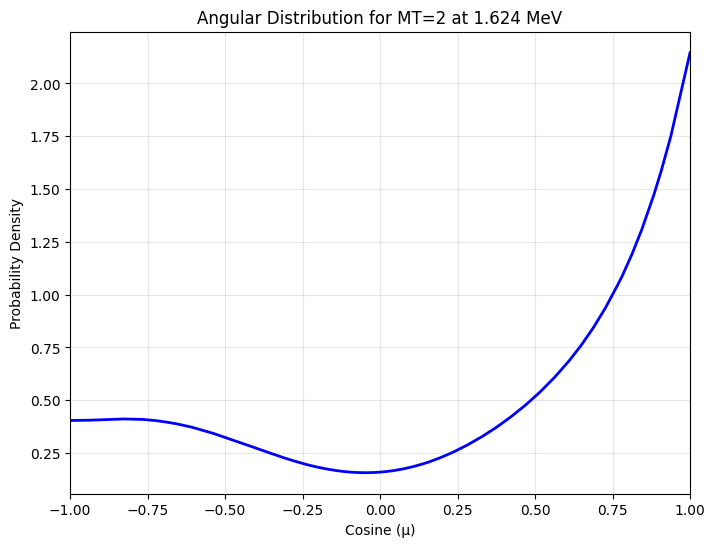

In [14]:
ene = ace0.angular_distributions.elastic.energies
ace0.angular_distributions.elastic.plot(energy=ene[3000])

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Angular Distribution for MT=2 at 1.624 MeV'}, xlabel='Cosine (μ)', ylabel='Probability Density'>)

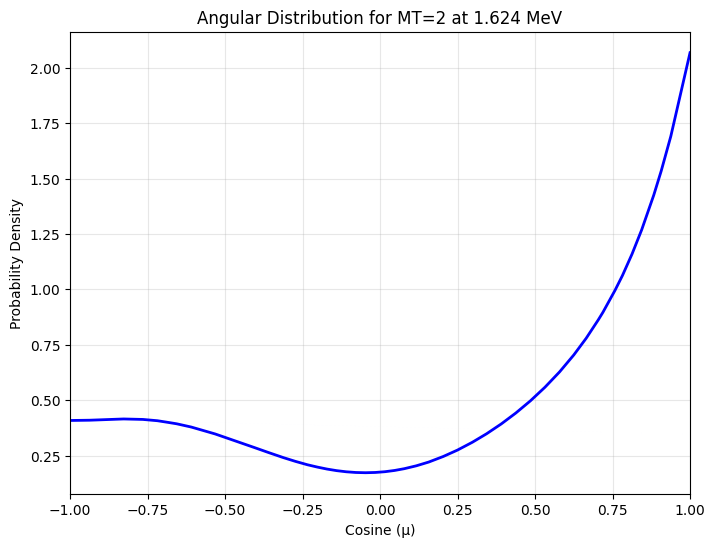

In [13]:
ene = ace1.angular_distributions.elastic.energies
ace1.angular_distributions.elastic.plot(energy=ene[3000])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import Legendre

In [51]:
num = 100

In [52]:
pdf = np.array(ace.angular_distributions.elastic.pdf[num])
cosines = np.array(ace.angular_distributions.elastic.cosine_grid[num])

In [73]:
L_max = 4

/tmp/ipykernel_20970/3044299134.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  a_ell = np.trapz(pdf * P_ell, cosines)


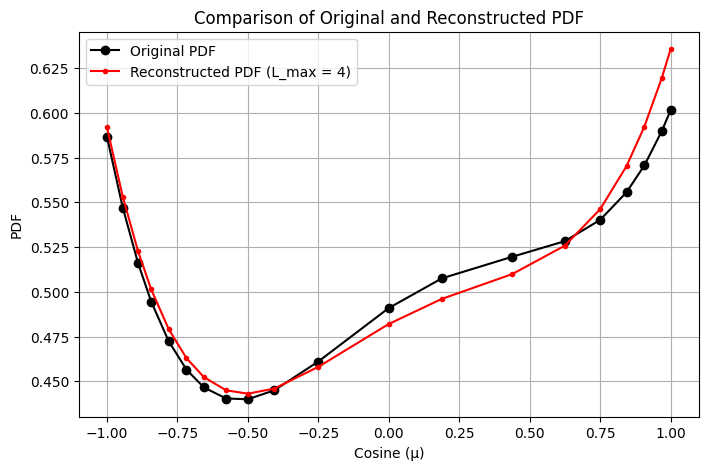

Legendre coefficients (up to order L_max = 10):
a_0 = 1.000000
a_1 = 0.031999
a_2 = 0.027723
a_3 = -0.007478
a_4 = 0.009865


In [74]:
# Function to compute Legendre coefficients from the PDF
def compute_legendre_coeffs(pdf, cosines, L_max):
    coeffs = []
    for ell in range(L_max+1):
        # Evaluate the Legendre polynomial P_ell at all cosine values.
        P_ell = Legendre.basis(ell)(cosines)
        # Compute the integral using the trapezoidal rule.
        a_ell = np.trapz(pdf * P_ell, cosines)
        coeffs.append(a_ell)
    return np.array(coeffs)

# Compute the Legendre coefficients
a_coeffs = compute_legendre_coeffs(pdf, cosines, L_max)

# Function to reconstruct the PDF from Legendre coefficients
def reconstruct_pdf(a_coeffs, cosines):
    f_rec = np.zeros_like(cosines)
    L_max = len(a_coeffs)-1
    for ell in range(L_max+1):
        P_ell = Legendre.basis(ell)(cosines)
        f_rec += 0.5 * (2*ell + 1) * a_coeffs[ell] * P_ell
    return f_rec

# Reconstruct the PDF from the Legendre coefficients
pdf_reconstructed = reconstruct_pdf(a_coeffs, cosines)

# Plot the original PDF and the reconstructed PDF
plt.figure(figsize=(8, 5))
plt.plot(cosines, pdf, 'ko-', label='Original PDF')
plt.plot(cosines, pdf_reconstructed, 'r.-', label=f'Reconstructed PDF (L_max = {L_max})')
plt.xlabel('Cosine (μ)')
plt.ylabel('PDF')
plt.title('Comparison of Original and Reconstructed PDF')
plt.legend()
plt.grid(True)
plt.show()

# For further analysis, let's print the computed Legendre coefficients.
print("Legendre coefficients (up to order L_max = 10):")
for ell, coeff in enumerate(a_coeffs):
    print(f"a_{ell} = {coeff:.6f}")


/tmp/ipykernel_20970/2872562681.py:14: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pdf = pdf / np.trapz(pdf, mu)


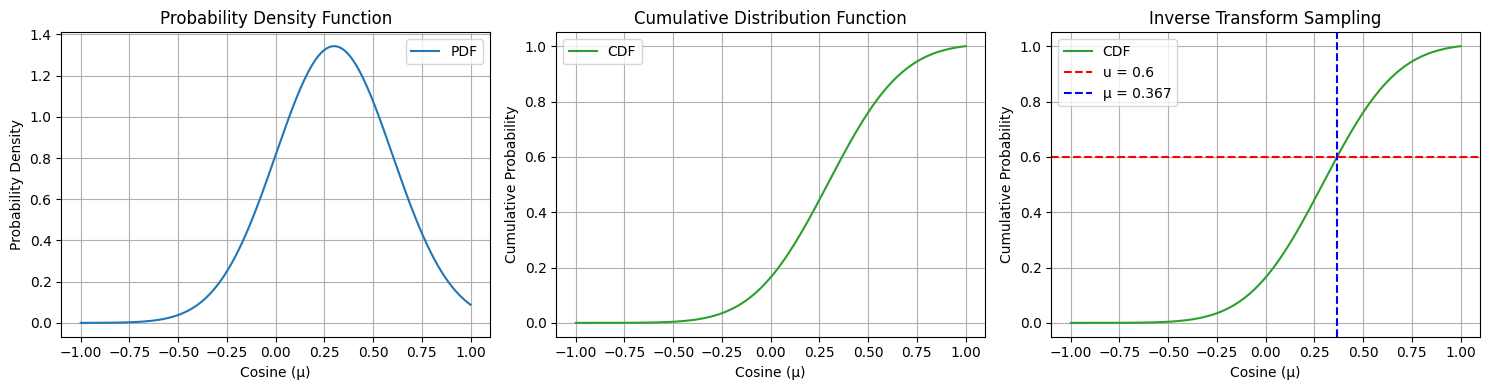

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Define a cosine grid (more points for smooth curves in the demonstration)
mu = np.linspace(-1, 1, 200)

# Construct a PDF. For example, use a Gaussian-like function in cosine space 
# to simulate an anisotropic scattering distribution.
mu_center = 0.3  # center of the peak (can be adjusted to simulate forward/backward bias)
sigma = 0.3
pdf = np.exp(-((mu - mu_center)**2) / (2 * sigma**2))

# Normalize the PDF so the integral over [-1, 1] is 1
pdf = pdf / np.trapz(pdf, mu)

# Compute the CDF by a cumulative numerical integration (using a cumulative sum)
cdf = np.cumsum(pdf * (mu[1] - mu[0]))  # multiply by bin width
cdf = cdf / cdf[-1]  # ensure it ends at exactly 1

# Plot the PDF and CDF side by side, plus a demonstration of sampling.
plt.figure(figsize=(15, 4))

# Plot 1: PDF
plt.subplot(1, 3, 1)
plt.plot(mu, pdf, label='PDF', color='C0')
plt.title('Probability Density Function')
plt.xlabel('Cosine (μ)')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)

# Plot 2: CDF
plt.subplot(1, 3, 2)
plt.plot(mu, cdf, label='CDF', color='C2')
plt.title('Cumulative Distribution Function')
plt.xlabel('Cosine (μ)')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)

# Plot 3: Inverse Transform Sampling Demonstration
# Choose an example random value u (like what the transport code would generate)
u = 0.6  # in a real case, u would be randomly drawn from Uniform[0,1]
# Find the cosine value corresponding to u using interpolation of the CDF
mu_sample = np.interp(u, cdf, mu)

plt.subplot(1, 3, 3)
plt.plot(mu, cdf, label='CDF', color='C2')
# Mark the horizontal line at u and the vertical line at the sampled cosine
plt.axhline(y=u, color='red', linestyle='--', label=f'u = {u}')
plt.axvline(x=mu_sample, color='blue', linestyle='--', label=f'μ = {mu_sample:.3f}')
plt.title('Inverse Transform Sampling')
plt.xlabel('Cosine (μ)')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


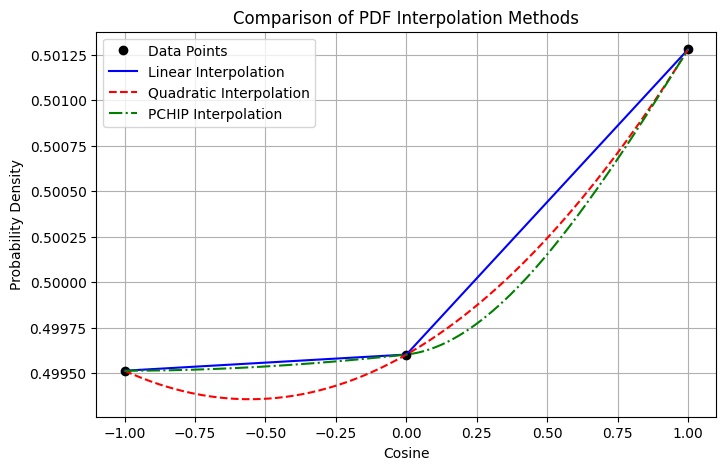

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, PchipInterpolator

# Given data points
cosine = np.array([-1.0, 0.0, 1.0])
pdf = np.array([0.4995137, 0.4996026, 0.5012811])
cdf = np.array([0.0, 0.4995582, 1.0])

# Create a dense set of points for plotting
xnew = np.linspace(-1, 1, 200)

# Linear interpolation: directly connects the data points.
linear_interp = interp1d(cosine, pdf, kind='linear')
pdf_linear = linear_interp(xnew)

# Quadratic interpolation: now works with 3 points.
quadratic_interp = interp1d(cosine, pdf, kind='quadratic')
pdf_quadratic = quadratic_interp(xnew)

# Alternatively, using a monotonic interpolator like PCHIP
pchip_interp = PchipInterpolator(cosine, pdf)
pdf_pchip = pchip_interp(xnew)

# Plotting the results
plt.figure(figsize=(8, 5))
plt.plot(cosine, pdf, 'ko', label='Data Points')
plt.plot(xnew, pdf_linear, 'b-', label='Linear Interpolation')
plt.plot(xnew, pdf_quadratic, 'r--', label='Quadratic Interpolation')
plt.plot(xnew, pdf_pchip, 'g-.', label='PCHIP Interpolation')
plt.xlabel('Cosine')
plt.ylabel('Probability Density')
plt.title('Comparison of PDF Interpolation Methods')
plt.legend()
plt.grid(True)
plt.show()


In [36]:
# Get the list of original energy points
energy_points = elastic_dist.energies

# Find the closest energy point to your target energy
target_energy = 1  # MeV
closest_idx = min(range(len(energy_points)), key=lambda i: abs(energy_points[i] - target_energy))
closest_energy = energy_points[closest_idx]

print(f"Closest energy point in the file: {closest_energy} MeV")

# Get data for this exact energy point (no interpolation)
df = elastic_dist.to_dataframe(energy=closest_energy, interpolate=False)
df

Closest energy point in the file: 1.0 MeV


energy  cosine       pdf       cdf
0      1.0 -1.0000  0.851466  0.000000
1      1.0 -0.9760  0.808314  0.019745
2      1.0 -0.9520  0.771001  0.038674
3      1.0 -0.9290  0.740367  0.056104
4      1.0 -0.9060  0.714097  0.072935
5      1.0 -0.8760  0.687532  0.093840
6      1.0 -0.8430  0.663859  0.116044
7      1.0 -0.8120  0.644864  0.136406
8      1.0 -0.7730  0.626523  0.161078
9      1.0 -0.7180  0.603946  0.194277
10     1.0 -0.5310  0.529213  0.300893
11     1.0 -0.4680  0.498480  0.333212
12     1.0 -0.3900  0.456649  0.370222
13     1.0 -0.2960  0.403101  0.408971
14     1.0 -0.1560  0.326846  0.462374
15     1.0 -0.0937  0.299110  0.481873
16     1.0 -0.0468  0.281722  0.495493
17     1.0  0.0000  0.267754  0.508351
18     1.0  0.0469  0.257374  0.520665
19     1.0  0.0938  0.250732  0.532580
20     1.0  0.1410  0.247837  0.544347
21     1.0  0.1880  0.248667  0.556014
22     1.0  0.2350  0.253087  0.567806
23     1.0  0.2820  0.260972  0.579886
24     1.0  0.3290  0.272412  0.592442
25     1.0  0.3910  0.292251  0.609892
26     1.0  0.4380  0.311582  0.624082
27     1.0  0.4690  0.326518  0.633973
28     1.0  0.5160  0.353007  0.649942
29     1.0  0.5630  0.385100  0.667287
30     1.0  0.5940  0.410058  0.679612
31     1.0  0.6330  0.446759  0.696320
32     1.0  0.6570  0.472848  0.707355
33     1.0  0.6880  0.512036  0.722778
34     1.0  0.7270  0.568619  0.743665
35     1.0  0.7580  0.622853  0.762132
36     1.0  0.7900  0.689550  0.783314
37     1.0  0.8210  0.764276  0.805838
38     1.0  0.8440  0.826760  0.823937
39     1.0  0.8740  0.921694  0.850196
40     1.0  0.8990  1.011876  0.874276
41     1.0  0.9230  1.110207  0.899741
42     1.0  0.9460  1.216067  0.926493
43     1.0  0.9690  1.334559  0.955825
44     1.0  0.9970  1.497803  0.995478
45     1.0  1.0000  1.516628  1.000000

In [5]:
ace.unresolved_resonance

                       Unresolved Resonance Probability Tables                       

No unresolved resonance probability tables available

In [6]:
acefile1 = 'files/922350_71.02c'

In [7]:
ace1 = kika.read_ace(acefile1)

In [ ]:
ace1.unresolved_resonance

[XssEntry(Index=745964, Value=0.002250001),
 XssEntry(Index=745965, Value=0.0025),
 XssEntry(Index=745966, Value=0.0035),
 XssEntry(Index=745967, Value=0.0045),
 XssEntry(Index=745968, Value=0.0055),
 XssEntry(Index=745969, Value=0.0065),
 XssEntry(Index=745970, Value=0.0075),
 XssEntry(Index=745971, Value=0.0085),
 XssEntry(Index=745972, Value=0.0095),
 XssEntry(Index=745973, Value=0.0131),
 XssEntry(Index=745974, Value=0.015),
 XssEntry(Index=745975, Value=0.02),
 XssEntry(Index=745976, Value=0.024),
 XssEntry(Index=745977, Value=0.02499999)]

In [ ]:
#JXS(32)
3302476 + 10 *(1-1) + 8

3302484

In [ ]:
# JED de DLWH
3317561 + 96 - 1

3317656

In [ ]:
ace.energy_distributions.get_neutron_distribution(5)[0].distributions


[]

In [ ]:
dist = ang.incident_neutron[16]
dist

                      Kalbach-Mann Angular Distribution Details                      

This object represents an angular distribution using the Kalbach-Mann formalism.
The Kalbach-Mann model correlates energy and angle distributions, with parameters
R (precompound fraction) and A (angular slope) that vary with outgoing energy.

Data Structure Overview:
- In the ACE file, a LOCB value of -1 indicates a Kalbach-Mann distribution
- The actual angular distribution parameters (R and A) are stored in the
  energy distribution section as a Law=44 distribution
- This object stores reference indices to locate the Law=44 data when needed

IMPORTANT: This distribution REQUIRES Law=44 data from the energy distribution
section (DLW/DLWH blocks). The ACE object must be provided to all methods that
calculate or sample angular distributions. Without this data, methods will raise
a Law44DataError exception.

Data Information:
-----------------------------------------------------------------------------

In [ ]:
ace.energy_distributions

                            Energy Distribution Container                            

This container holds energy distributions for secondary particles produced in nuclear reactions.
Distributions are organized by particle type (neutron, photon, other) and reaction (MT number).
Each reaction can have multiple distribution laws that apply in different energy ranges.

Available Energy Distribution Data:
-------------------------------------------------------------------------------------
Distribution Type                        Status                                    
-------------------------------------------------------------------------------------
Incident Neutron Distributions           Available (42 MT numbers)                 
Photon Production Distributions          Available (532 MT numbers)                
Particle Production Distributions        Available (5 particle types)              
Delayed Neutron Distributions            None (0 groups)                           
En

In [ ]:
ace.energy_distributions.print_distribution_info()

                                Energy Distribution Type Information                                

Incident Neutron Energy Distributions
----------------------------------------------------------------------------------------------------
MT       Law      Distribution Type              Access Method                                     
----------------------------------------------------------------------------------------------------
5        61       TabulatedAngleEnergyDistribution .get_neutron_distribution(5)                      
16       61       TabulatedAngleEnergyDistribution .get_neutron_distribution(16)                     
51       3        LevelScattering                .get_neutron_distribution(51)                     
52       3        LevelScattering                .get_neutron_distribution(52)                     
53       3        LevelScattering                .get_neutron_distribution(53)                     
54       3        LevelScattering                .get_

In [ ]:
ace.energy_distributions.get_neutron_distribution(5)[0]

                  Tabulated Angle-Energy Distribution (Law 61)                  
This distribution provides correlated angle-energy distributions using tabular
angular distributions. It corresponds to Law 61 in the ACE format.
Similar to LAW=44 but uses tabular angular distributions instead of Kalbach-Mann formalism.

Basic Properties:
--------------------------------------------------------------------------------
Distribution Law                         61 (Tabulated Angle-Energy)          
Number of Interpolation Regions          2                                    
Number of Incident Energies              0                                    
Number of Energy Distributions           0                                    
Number of Angular Tables                 0                                    
--------------------------------------------------------------------------------

Available Methods:
--------------------------------------------------------------------------------
Meth

In [ ]:
ace.energy_distributions.get_neutron_distribution(5)[0].applicability_energies

[XssEntry(Index=2067964, Value=1e-11),
 XssEntry(Index=2067965, Value=6.0),
 XssEntry(Index=2067966, Value=10.5),
 XssEntry(Index=2067967, Value=11.0),
 XssEntry(Index=2067968, Value=11.25),
 XssEntry(Index=2067969, Value=11.5),
 XssEntry(Index=2067970, Value=12.0),
 XssEntry(Index=2067971, Value=12.5),
 XssEntry(Index=2067972, Value=13.0),
 XssEntry(Index=2067973, Value=13.5),
 XssEntry(Index=2067974, Value=14.0),
 XssEntry(Index=2067975, Value=14.5),
 XssEntry(Index=2067976, Value=15.0),
 XssEntry(Index=2067977, Value=16.0),
 XssEntry(Index=2067978, Value=16.5),
 XssEntry(Index=2067979, Value=18.0),
 XssEntry(Index=2067980, Value=19.0),
 XssEntry(Index=2067981, Value=20.0),
 XssEntry(Index=2067982, Value=22.0),
 XssEntry(Index=2067983, Value=24.0),
 XssEntry(Index=2067984, Value=25.7),
 XssEntry(Index=2067985, Value=28.0),
 XssEntry(Index=2067986, Value=30.0),
 XssEntry(Index=2067987, Value=32.0),
 XssEntry(Index=2067988, Value=34.0),
 XssEntry(Index=2067989, Value=36.0),
 XssEntry(I

In [ ]:
ang.incident_neutron[51].to_dataframe(energy=14)

cosine  probability
0  -1.000000     0.099977
1  -0.979798     0.219170
2  -0.959596     0.294011
3  -0.939394     0.335204
4  -0.919192     0.350943
..       ...          ...
95  0.919192     1.159403
96  0.939394     0.984290
97  0.959596     0.777105
98  0.979798     0.550318
99  1.000000     0.323685

[100 rows x 2 columns]

In [ ]:
acefile_og = 'files/260560_80.06c_0002'
acefile_pert = 'files/260560_80.06c_0001'

In [ ]:
ace_og = kika.read_ace(acefile_og)
ace_pert = kika.read_ace(acefile_pert)

KeyboardInterrupt: 

In [ ]:
df = get_cross_section_dataframe([ace_og, ace_pert], 51)
df

Energy     26056   26056_1
0      1.000000e-11  0.000000  0.000000
1      1.031250e-11  0.000000  0.000000
2      1.062500e-11  0.000000  0.000000
3      1.093750e-11  0.000000  0.000000
4      1.125000e-11  0.000000  0.000000
...             ...       ...       ...
41041  1.250000e+02  0.005195  0.005195
41042  1.300000e+02  0.004796  0.004796
41043  1.400000e+02  0.004115  0.004115
41044  1.499999e+02  0.003563  0.003563
41045  1.500000e+02  0.003563  0.003563

[41046 rows x 3 columns]

Are the columns exactly the same? False
Maximum absolute difference: 0.24363707434000004


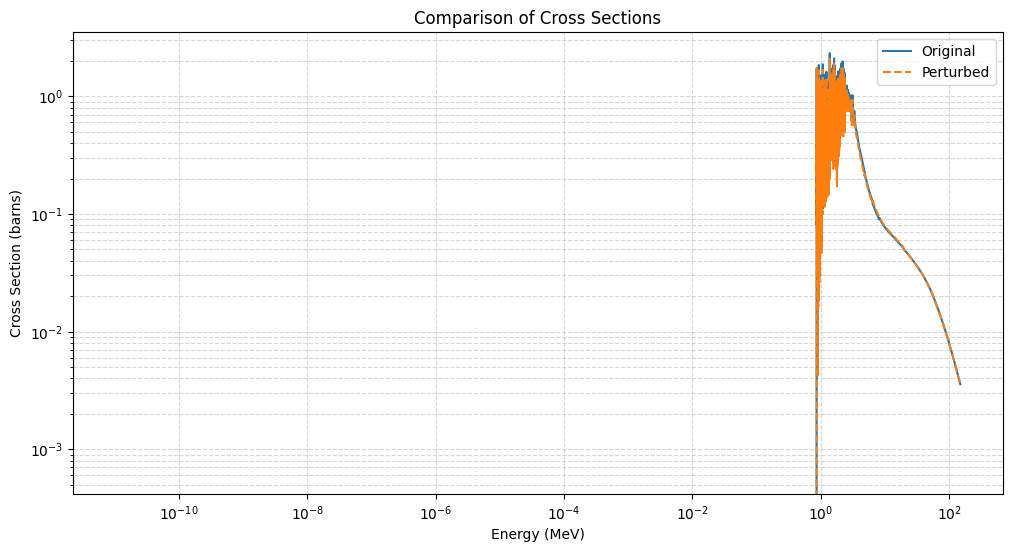

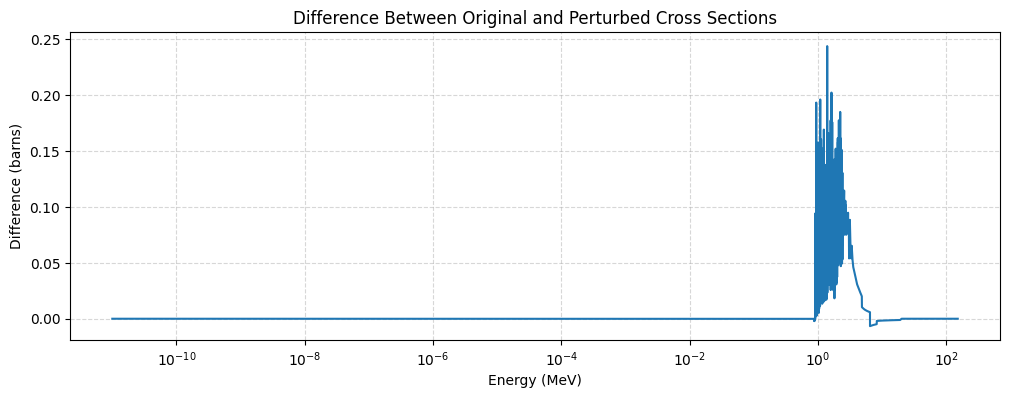

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

# Check if both columns are exactly the same
exact_match = (df[26056] == df['26056_1']).all()
print(f"Are the columns exactly the same? {exact_match}")

# Calculate the absolute difference between columns
diff = df[26056] - df['26056_1']
max_diff = np.abs(diff).max()
print(f"Maximum absolute difference: {max_diff}")

# Plot both cross sections
plt.figure(figsize=(12, 6))
plt.plot(df['Energy'], df[26056], label='Original')
plt.plot(df['Energy'], df['26056_1'], label='Perturbed', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy (MeV)')
plt.ylabel('Cross Section (barns)')
plt.title('Comparison of Cross Sections')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)

# Plot the difference
if not exact_match:
    plt.figure(figsize=(12, 4))
    plt.plot(df['Energy'], diff)
    plt.xscale('log')
    plt.xlabel('Energy (MeV)')
    plt.ylabel('Difference (barns)')
    plt.title('Difference Between Original and Perturbed Cross Sections')
    plt.grid(True, which='both', linestyle='--', alpha=0.5)

In [ ]:
.

SyntaxError: invalid syntax (1933637684.py, line 1)

In [ ]:
# Define all ACE files to test
acefile = 'files/10010_71.02c'
acefile_U235 = 'files/922350_71.02c'
acefile1 = 'files/FE56.293600c'
acefile2 = 'files/260560_80.02c'

# Print files to verify they exist
for file_path in [acefile, acefile_U235, acefile1, acefile2]:
    print(f"File {file_path} exists: {os.path.exists(file_path)}")

File files/10010_71.02c exists: True
File files/922350_71.02c exists: True
File files/FE56.293600c exists: True
File files/260560_80.02c exists: True


In [ ]:
ace_U235 = kika.read_ace(acefile_U235)

In [ ]:
ace_U235.unresolved_resonance

Unresolved Resonance Probability Tables
Number of energy points: 14
Table length: 20
Interpolation: linear-linear
Inelastic cross section: special MT=4
Other absorption cross section: zero in the unresolved range
Table values represent factors to multiply smooth cross sections
Energy range: 2.250001e-03 to 2.499999e-02 MeV
Total cross section range: 6.280051e-01 to 1.891055e+00 (factors)

In [ ]:
print(ace_U235.mt_numbers)

[1, 2, 4, 16, 17, 18, 37, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 101, 102, 444]


In [ ]:
ace_U235.cross_section.reaction.keys()

dict_keys([1, 2, 101, 16, 17, 18, 37, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 102, 444, 4])

In [ ]:
print(ace_U235.cross_section.mt_numbers)

[1, 2, 4, 16, 17, 18, 37, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 101, 102, 444]


In [ ]:
ace_U235.cross_section.reaction[4].to_dataframe()

Energy  Cross Section
0     0.00225   0.000000e+00
1     0.00225   1.204971e-07
2     0.00230   1.251350e-07
3     0.00240   1.342625e-07
4     0.00250   1.433900e-07
..        ...            ...
425  18.00000   4.111469e-01
426  18.50000   3.994417e-01
427  19.00000   3.882021e-01
428  19.50000   3.764036e-01
429  20.00000   3.650166e-01

[430 rows x 2 columns]

In [ ]:
ace_U235.cross_section.to_dataframe()

Energy          MT=1       MT=2      MT=4     MT=16     MT=17  \
0      1.000000e-11  37407.199500  58.331490  0.000000  0.000000  0.000000   
1      1.031250e-11  36836.060100  57.493120  0.000000  0.000000  0.000000   
2      1.062500e-11  36290.312800  56.692750  0.000000  0.000000  0.000000   
3      1.093750e-11  35768.122700  55.927650  0.000000  0.000000  0.000000   
4      1.125000e-11  35267.846300  55.195330  0.000000  0.000000  0.000000   
...             ...           ...        ...       ...       ...       ...   
76520  1.800000e+01      6.124479   3.134972  0.411147  0.211427  0.308173   
76521  1.850000e+01      6.147738   3.170238  0.399442  0.193505  0.340188   
76522  1.900000e+01      6.159560   3.190453  0.388202  0.178435  0.370183   
76523  1.950000e+01      6.165319   3.206368  0.376404  0.165893  0.393329   
76524  2.000000e+01      6.169678   3.216437  0.365017  0.155512  0.407009   

              MT=18         MT=37  MT=51  MT=52  ...     MT=85     MT=86  \
0      31390.430000  0.000000e+00    0.0    0.0  ...  0.000000  0.000000   
1      30911.110000  0.000000e+00    0.0    0.0  ...  0.000000  0.000000   
2      30453.100000  0.000000e+00    0.0    0.0  ...  0.000000  0.000000   
3      30014.860000  0.000000e+00    0.0    0.0  ...  0.000000  0.000000   
4      29595.010000  0.000000e+00    0.0    0.0  ...  0.000000  0.000000   
...             ...           ...    ...    ...  ...       ...       ...   
76520      2.058403  3.810030e-07    0.0    0.0  ...  0.003198  0.001200   
76521      2.043946  8.441785e-05    0.0    0.0  ...  0.003089  0.001158   
76522      2.031731  2.387410e-04    0.0    0.0  ...  0.002983  0.001119   
76523      2.021675  1.348763e-03    0.0    0.0  ...  0.002881  0.001081   
76524      2.020631  4.785594e-03    0.0    0.0  ...  0.002785  0.001045   

          MT=87     MT=88     MT=89     MT=90     MT=91       MT=101  \
0      0.000000  0.000000  0.000000  0.000000  0.000000  5958.438000   
1      0.000000  0.000000  0.000000  0.000000  0.000000  5867.457000   
2      0.000000  0.000000  0.000000  0.000000  0.000000  5780.520000   
3      0.000000  0.000000  0.000000  0.000000  0.000000  5697.335000   
4      0.000000  0.000000  0.000000  0.000000  0.000000  5617.641000   
...         ...       ...       ...       ...       ...          ...   
76520  0.001310  0.001362  0.001021  0.001134  0.123749     0.000357   
76521  0.001265  0.001315  0.000985  0.001095  0.119950     0.000335   
76522  0.001222  0.001269  0.000951  0.001057  0.116218     0.000317   
76523  0.001180  0.001226  0.000919  0.001021  0.111520     0.000302   
76524  0.001141  0.001186  0.000889  0.000988  0.106818     0.000287   

            MT=102      MT=444  
0      5958.438000  220.971000  
1      5867.457000  217.596900  
2      5780.520000  214.372700  
3      5697.335000  211.287800  
4      5617.641000  208.332300  
...            ...         ...  
76520     0.000357    0.219410  
76521     0.000335    0.222942  
76522     0.000317    0.226554  
76523     0.000302    0.229946  
76524     0.000287    0.233585  

[76525 rows x 52 columns]

In [ ]:
# Filter df to show values in the specified energy range
energy_range = df[(df['Energy'] >= 2.249703e-3) & (df['Energy'] <= 3e-3)]
display(energy_range)

# Optional: Show how many rows are in this range
print(f"Number of points in this energy range: {len(energy_range)}")

NameError: name 'df' is not defined

In [ ]:
loc = 459766
print((loc)/4+13-0.25)

114954.25


In [1]:
import sandy
sandy.get_njoy()

'/home/MONLEON-JUAN/NJOY2016/NJOY2016-main/build/njoy'